# 3. 시각화 예제

> plot.ly 라이브러리를 활용하여 간단한 시각화 예제를 시도해 보았습니다

In [36]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
from IPython.display import display, display_pretty, clear_output, JSON

spark = (
    SparkSession
    .builder
    .config("spark.sql.session.timeZone", "Asia/Seoul")
    .getOrCreate()
)

# 노트북에서 테이블 형태로 데이터 프레임 출력을 위한 설정을 합니다
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # display enabled
spark.conf.set("spark.sql.repl.eagerEval.truncate", 100) # display output columns size

# 공통 데이터 위치
home_jovyan = "/home/jovyan"
work_data = f"{home_jovyan}/work/data"
work_dir=!pwd
work_dir = work_dir[0]

# 로컬 환경 최적화
spark.conf.set("spark.sql.shuffle.partitions", 5) # the number of partitions to use when shuffling data for joins or aggregations.
spark.conf.set("spark.sql.streaming.forceDeleteTempCheckpointLocation", "true")
spark

### 3-1. 일자별 접속 및 매출 추세

> 일자별 지표는 레이턴시가 보장되는 관계형 데이터베이스 혹은 NoSQL 에 저장되어 있다고 가정하고, 해당 데이터를 JDBC를 통해 가져온 다음 아래와 같은 리포트를 생성할 수 있습니다.

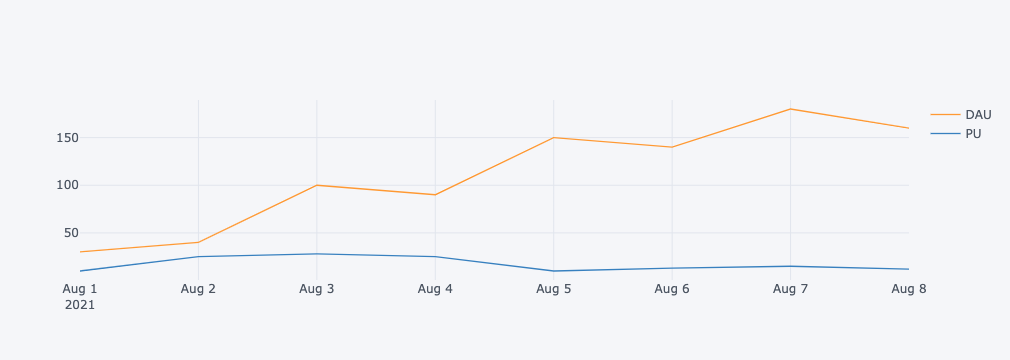

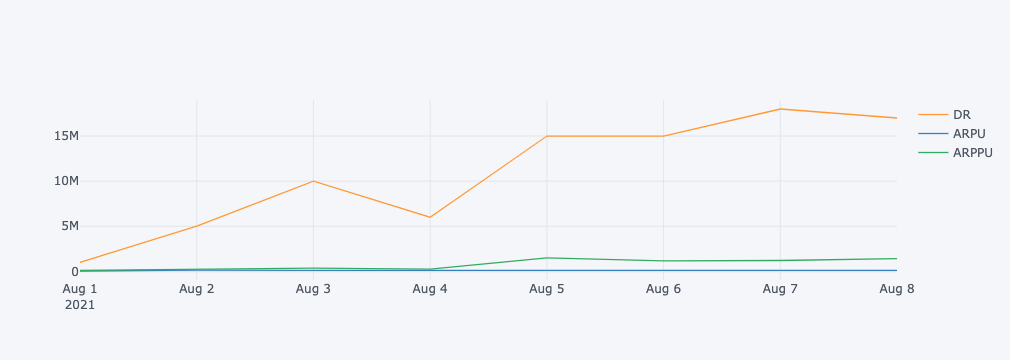

In [37]:
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline(connected=True)

raw = (
    spark.createDataFrame(
        [
            ("2021-08-01", 30, 10, 1000000)
            , ("2021-08-02", 40, 25, 5000000)
            , ("2021-08-03", 100, 28, 10000000)
            , ("2021-08-04", 90, 25, 6000000)
            , ("2021-08-05", 150, 10, 15000000)
            , ("2021-08-06", 140, 13, 15000000)
            , ("2021-08-07", 180, 15, 18000000)
            , ("2021-08-08", 160, 12, 17000000)
        ], ["DT", "DAU", "PU", "DR"]
    )
)

data = raw.withColumn("ARPU", expr("round(DR / DAU)")).withColumn("ARPPU", expr("round(DR / PU)"))

# DAU, PU - 접속
users = data.withColumn("datetime", to_date(col('DT'), 'yyyy-MM-dd')).drop("DT", "DR", "ARPU", "ARPPU")
pdUsers = users.toPandas().set_index('datetime')
pdUsers.iplot(kind='line')

# DR, ARPU, ARPPU - 매출
purchase = data.withColumn("datetime", to_date(col('DT'), 'yyyy-MM-dd')).drop("DT", "DAU", "PU")
pdPurchase = purchase.toPandas().set_index('datetime')
pdPurchase.iplot(kind='line')

<br>

### 3-2. 성별 구매 통계

> 디멘젼 테이블을 통해서 성별 구매 금액과 횟수를 시각화 합니다

In [38]:
dimension = spark.read.parquet(f"{work_dir}/dimension/dt=20201026")
display(dimension)

d_uid,d_name,d_gender,d_acount,d_pamount,d_pcount,d_first_purchase
9,최컴퓨터,남,1,2500000,1,2020-10-26 07:49:15
7,임모바일,남,1,3500000,1,2020-10-26 07:45:55
8,조노트북,여,1,0,0,null
3,박트롬,여,3,1000000,1,2020-10-25 05:42:35
4,청소기,남,5,0,0,null
1,정휘센,남,3,5200000,3,2020-10-25 05:32:30
2,김싸이언,남,5,1400000,1,2020-10-25 11:38:20
5,유코드제로,여,3,7000000,3,2020-10-25 09:32:35
6,윤디오스,남,1,4500000,1,2020-10-26 10:08:20


In [39]:
gender = dimension.select("d_name", "d_gender", "d_pcount", "d_pamount").toPandas()
display(gender)

,d_name,d_gender,d_pcount,d_pamount
0,최컴퓨터,남,1,2500000
1,임모바일,남,1,3500000
2,조노트북,여,0,0
3,박트롬,여,1,1000000
4,청소기,남,0,0
5,정휘센,남,3,5200000
6,김싸이언,남,1,1400000
7,유코드제로,여,3,7000000
8,윤디오스,남,1,4500000


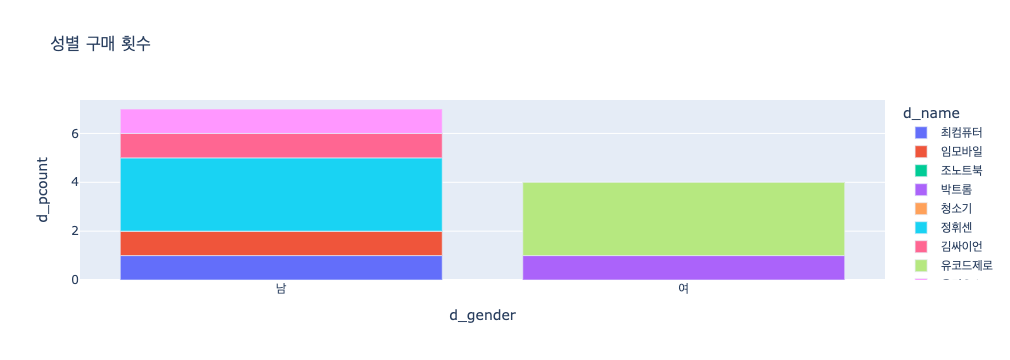

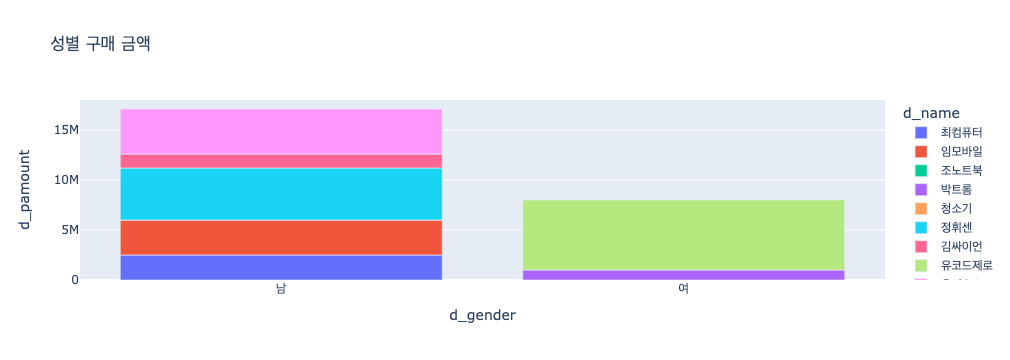

In [40]:
import plotly.express as px

fig = px.bar(gender, x="d_gender", y="d_pcount", color="d_name", title="성별 구매 횟수")
fig.show()

fig = px.bar(gender, x="d_gender", y="d_pamount", color="d_name", title="성별 구매 금액")
fig.show()

<br>

### 3-3. 다양한 시각화 예제

### 참고자료
* [plot.ly bar-charts](https://plotly.com/python/bar-charts/)
* [plot.ly line-charts](https://plotly.com/python/line-charts/)
* [plot.ly express](https://plotly.com/python/px-arguments/)
* [plot.ly w/ apache spark](https://plotly.com/python/v3/apache-spark/)


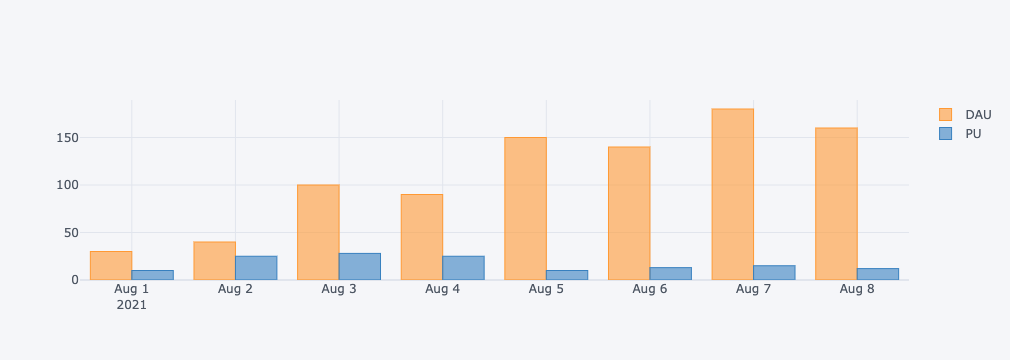

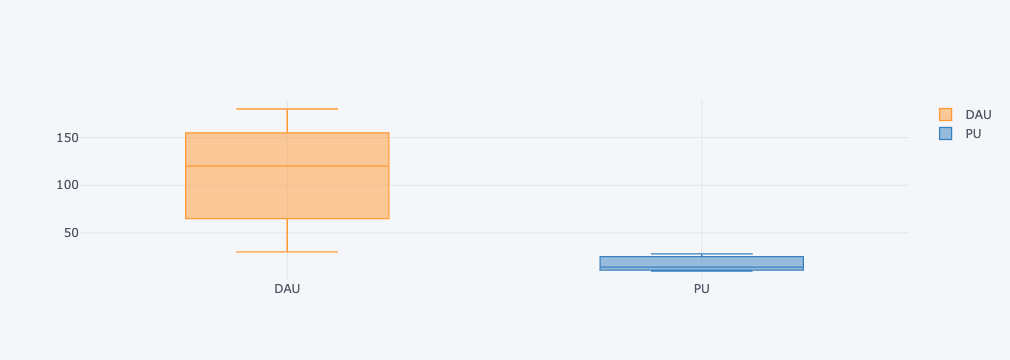

In [41]:
pdUsers.iplot(kind='bar')
pdUsers.iplot(kind='box')

In [42]:
import numpy as np
users = spark.createDataFrame([("2021-08-01", 30, 10), ("2021-08-02", 40, 28), ("2021-08-03", 100, 10), ("2021-08-04", 90, 30), ("2021-08-05", 150, 50)], ["DATE", "DAU", "DPU"])
users.show(truncate=False)

dt = np.array(users.select("DATE").collect()).reshape(-1)
y1 = np.array(users.select("DAU").collect()).reshape(-1)
y2 = np.array(users.select("DPU").collect()).reshape(-1)


+----------+---+---+
|DATE      |DAU|DPU|
+----------+---+---+
|2021-08-01|30 |10 |
|2021-08-02|40 |28 |
|2021-08-03|100|10 |
|2021-08-04|90 |30 |
|2021-08-05|150|50 |
+----------+---+---+



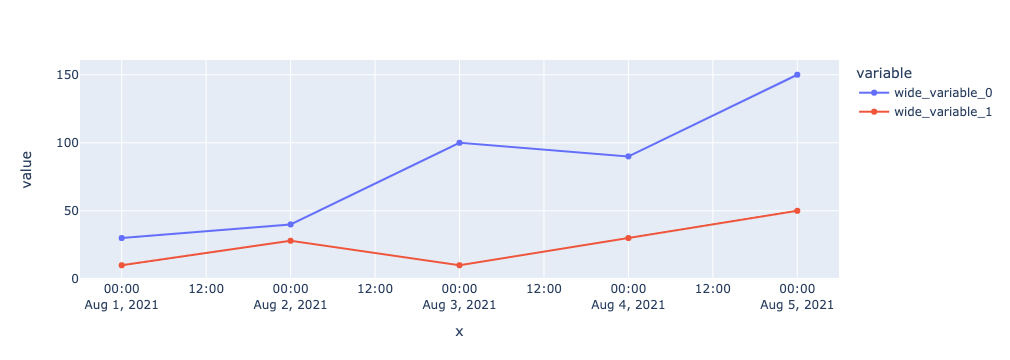

In [43]:
fig = px.line(x=dt, y=[y1, y2], markers=True)
fig.update_traces()
fig.show()

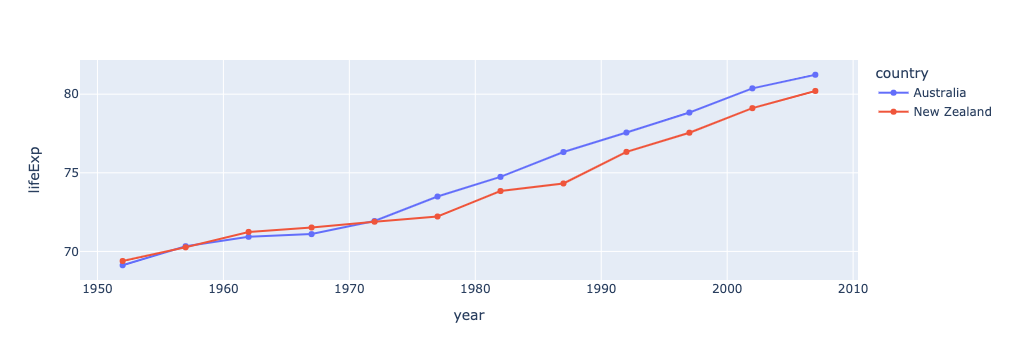

In [44]:
import plotly.express as px
df = px.data.gapminder().query("continent == 'Oceania'")
fig = px.line(df, x='year', y='lifeExp', color='country', markers=True)
fig.show()

In [45]:
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline(connected=True)

In [46]:
pdUsers.head()

,DAU,PU
datetime,,
2021-08-01,30,10
2021-08-02,40,25
2021-08-03,100,28
2021-08-04,90,25
2021-08-05,150,10


In [47]:
df = cf.datagen.lines()
df.head()

,KTB.FC,MMD.IY,PIQ.ZL,CAK.VC,VBB.EZ
2015-01-01,-0.046350,-0.955022,-0.916212,-0.010166,2.171575
2015-01-02,0.623321,-1.201441,-0.524688,-0.869669,3.042005
2015-01-03,0.255641,-0.872098,0.565457,-1.240176,2.893095
2015-01-04,0.713342,-3.260165,0.831718,0.699972,1.119710
2015-01-05,-0.823548,-2.511620,-0.457198,0.845206,1.445354


In [48]:
print(df)

              KTB.FC    MMD.IY    PIQ.ZL    CAK.VC    VBB.EZ
2015-01-01 -0.046350 -0.955022 -0.916212 -0.010166  2.171575
2015-01-02  0.623321 -1.201441 -0.524688 -0.869669  3.042005
2015-01-03  0.255641 -0.872098  0.565457 -1.240176  2.893095
2015-01-04  0.713342 -3.260165  0.831718  0.699972  1.119710
2015-01-05 -0.823548 -2.511620 -0.457198  0.845206  1.445354
...              ...       ...       ...       ...       ...
2015-04-06  8.342208 -0.280237  7.297610 -2.820797 -0.087990
2015-04-07  8.311447  0.210921  6.988776 -2.598029  0.448693
2015-04-08  8.076642 -1.573045  5.840460 -2.237144  0.003371
2015-04-09  8.419239 -2.165239  5.291677 -2.122904  0.624892
2015-04-10  8.549897 -2.608292  3.005667 -0.678367  1.314055

[100 rows x 5 columns]


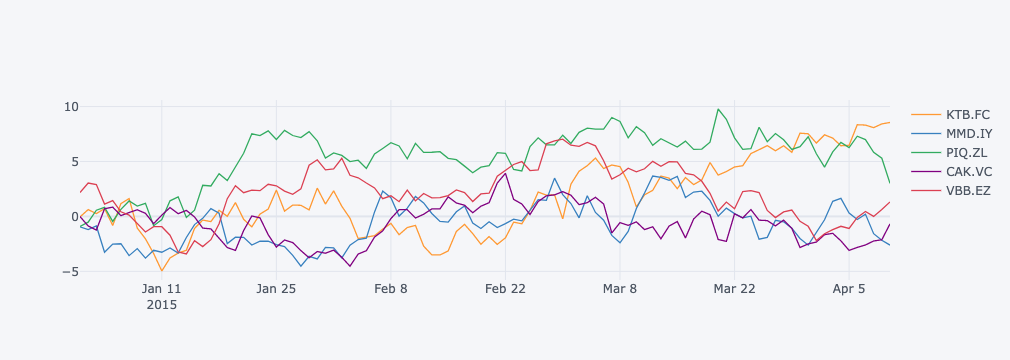

In [49]:
df.iplot(kind='line')

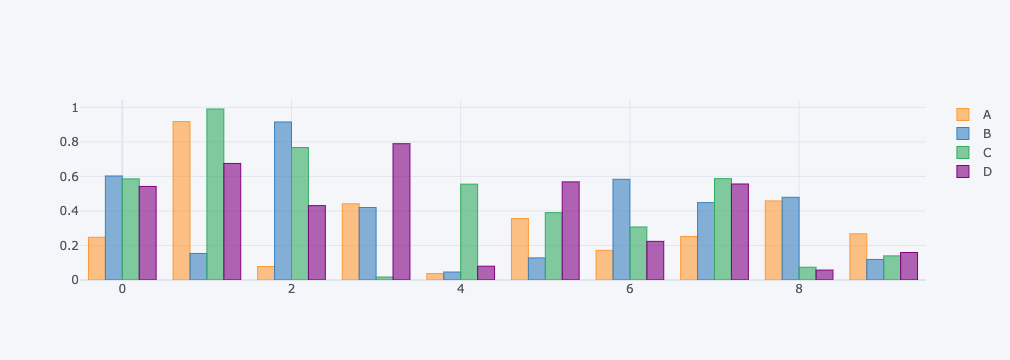

In [51]:
import numpy as np
import pandas as pd
df = pd.DataFrame(np.random.rand(10, 4), columns=['A', 'B', 'C', 'D'])
df.head()
df.iplot(kind='bar')

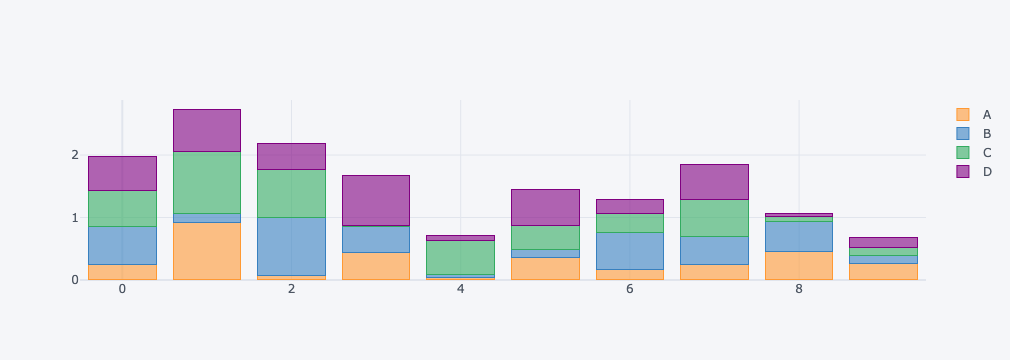

In [52]:
df.iplot(kind='bar', barmode='stack')

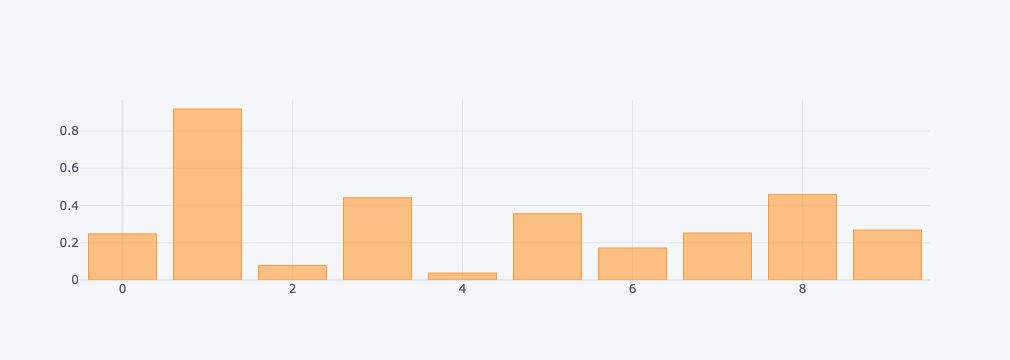

In [53]:
df['A'].iplot(kind='bar')

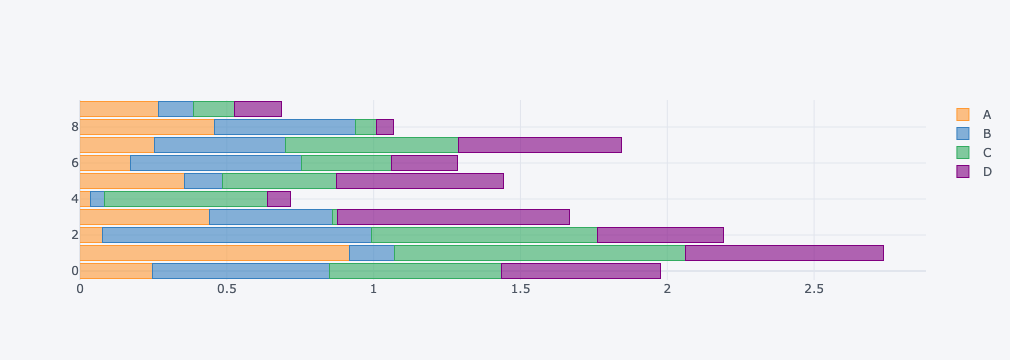

In [54]:
df.iplot(kind='barh', barmode='stack')

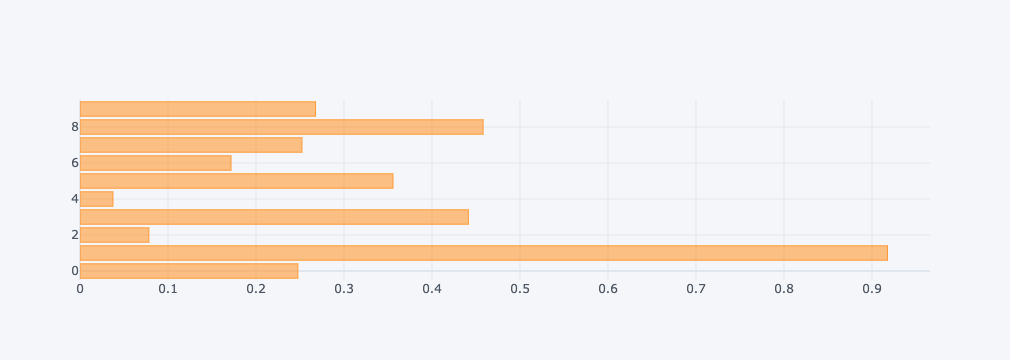

In [55]:

df['A'].iplot(kind='barh')
